# 3.0-Normalization and Embedding 

**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-09"

## Introduction

Normalize data and create embedding of the CD3+ enriched compartment from the T0 (tumor resection)

## Libraries

In [2]:
suppressMessages(suppressWarnings({
library(Seurat)
library(tidyverse)
library(grid)
library(gridExtra)
library(ggplot2)
library(scater) 
library(scran)
}))

## Parameters

In [3]:
#here::dr_here(show_reason = TRUE)
source(here::here("SCGRES_99_100/sc_analysis/misc/paths.R"))

"{clust}/{plt_dir}" %>%
  glue::glue() %>%
  here::here() %>%
  dir.create(path = .,
           showWarnings = FALSE,
           recursive = TRUE)

"{clust}/{robj_dir}" %>%
  glue::glue() %>%
  here::here() %>%
  dir.create(path = .,
           showWarnings = FALSE,
           recursive = TRUE)

set.seed(0)

## Load data

In [4]:
seurat_obj <- readRDS(here::here(glue::glue("{qc}/{robj_dir}/clean_combined_object_T0_CD3pos.rds")))
seurat_obj

An object of class Seurat 
29044 features across 14043 samples within 1 assay 
Active assay: RNA (29044 features, 0 variable features)

## Normalization and linear dimensional reduction

In [5]:
seurat_obj <- NormalizeData(
  seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)

In [6]:
sce <- as.SingleCellExperiment(seurat_obj)
sce

class: SingleCellExperiment 
dim: 29044 14043 
metadata(0):
assays(2): counts logcounts
rownames(29044): AL627309.1 AL627309.3 ... AC233755.1 AC007325.4
rowData names(0):
colnames(14043): AAACCTGAGCAGCCTC-1 AAACCTGAGCAGCGTA-1 ...
  TTTGTCATCTGGGCCA-1 TTTGTCATCTTGGGTA-1
colData names(12): orig.ident nCount_RNA ... doublet_pred ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


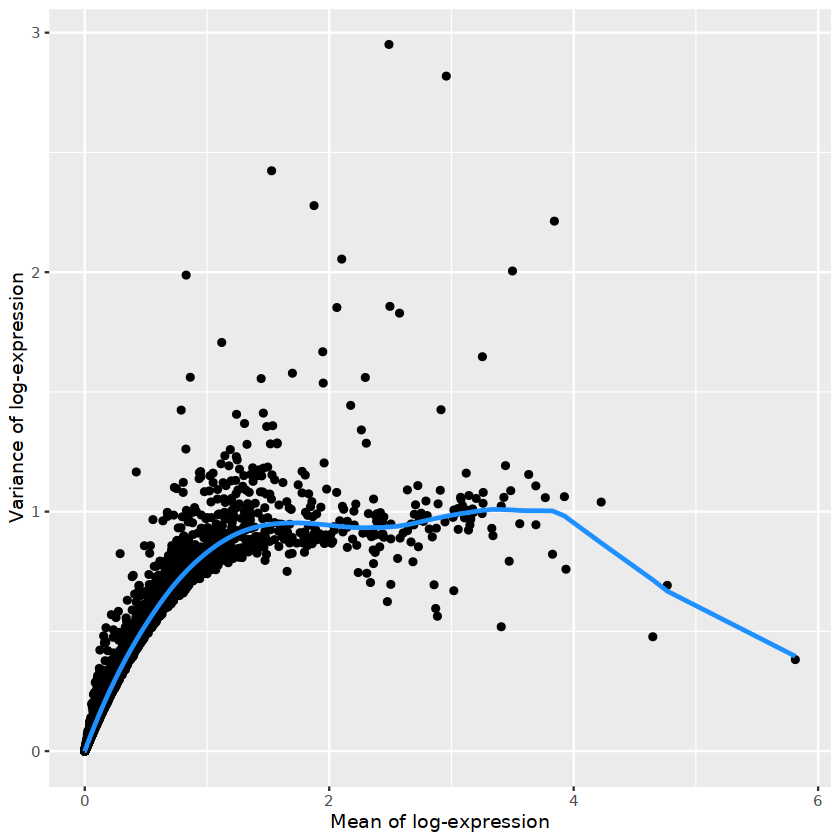

In [7]:
gene_var <- modelGeneVar(sce)
gene_var %>% 
  as.data.frame() %>% 
  ggplot(aes(mean, total)) +
  geom_point() +
  geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
  labs(x = "Mean of log-expression", y = "Variance of log-expression")

In [8]:
gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)

,mean,total,tech,bio,p.value,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NKG7,2.4888705,2.950813,0.9360172,2.0147961,2.601844e-95,2.439749e-91
CCL5,2.9578570,2.818630,0.9809535,1.8376769,1.004188e-72,2.824881e-69
CCL4,1.5284569,2.423315,0.9475485,1.4757660,6.377843e-51,8.970755e-48
FOS,1.8757504,2.277941,0.9491960,1.3287447,1.555922e-41,1.151833e-38
HSPA1A,3.8421025,2.212970,0.9995881,1.2133821,9.919598e-32,4.429337e-29
GZMK,2.1022024,2.054478,0.9375906,1.1168874,1.248758e-30,5.243105e-28
HSPA1B,3.4992575,2.004798,1.0069501,0.9978477,8.603472e-22,2.521086e-19
HSPA6,0.8294713,1.987633,0.7501768,1.2374567,7.243559e-57,1.455490e-53
JUN,2.4964004,1.857085,0.9362046,0.9208809,1.689946e-21,4.802006e-19


In [9]:
hvgs <- getTopHVGs(gene_var,fdr.threshold = 0.05)
length(hvgs)

[1] 785

In [10]:
hvgs <- hvgs[!grepl("^TR[ABDG][VJC]", hvgs)]
length(hvgs)

[1] 692

In [11]:
VariableFeatures(seurat_obj) <- hvgs

In [12]:
seurat_obj <- seurat_obj %>%
  ScaleData(features=hvgs) %>% 
  RunPCA(features=hvgs)

Centering and scaling data matrix

PC_ 1 
Positive:  VCAN, PLXDC2, LYZ, FCN1, RNF144B, SERPINA1, S100A9, KYNU, TLR2, CD163 
	   S100A8, SLC11A1, LILRB2, CD14, TYROBP, RAB31, FCGR2A, MNDA, CPVL, LRMDA 
	   CSF3R, CD36, THBS1, GLUL, FCER1G, FPR1, TREM1, DOCK4, SLC1A3, MSR1 
Negative:  CST7, CCL5, GZMK, NKG7, GZMA, IL32, CTSW, PRF1, RGS1, IFITM1 
	   CCL4, GZMB, CCL4L2, CD69, GZMH, VCAM1, CCL3, LINC01934, TNFRSF9, IFNG 
	   AL133405.2, HSPA1B, HSPA1A, FCGR3A, CD74, CTLA4, DNAJB1, IKZF2, FXYD2, CRTAM 
PC_ 2 
Positive:  COL1A2, MEG3, NFIB, LRFN5, NRG3, MEG8, AC109466.1, NFIA, ROBO1, CNTNAP2 
	   COL11A1, COL5A2, NLGN1, COL3A1, NRXN1, MDGA2, GPC3, AUTS2, PCDH9, TSHZ2 
	   CADM2, ERBB4, IGFBP5, COL25A1, CCSER1, FLRT2, MFAP4, NELL1, SPARC, MGP 
Negative:  LYZ, FCN1, CD74, SERPINA1, S100A9, PLXDC2, S100A8, RNF144B, KYNU, SLC11A1 
	   TYROBP, CD163, TLR2, LILRB2, CD14, MNDA, FCGR2A, CSF3R, FCER1G, GLUL 
	   NKG7, CPVL, LRMDA, FPR1, CCL5, CST7, HLA-DRB1, HSPA1A, GZMK, HLA-DRA 
PC_ 3 
Positive:  N

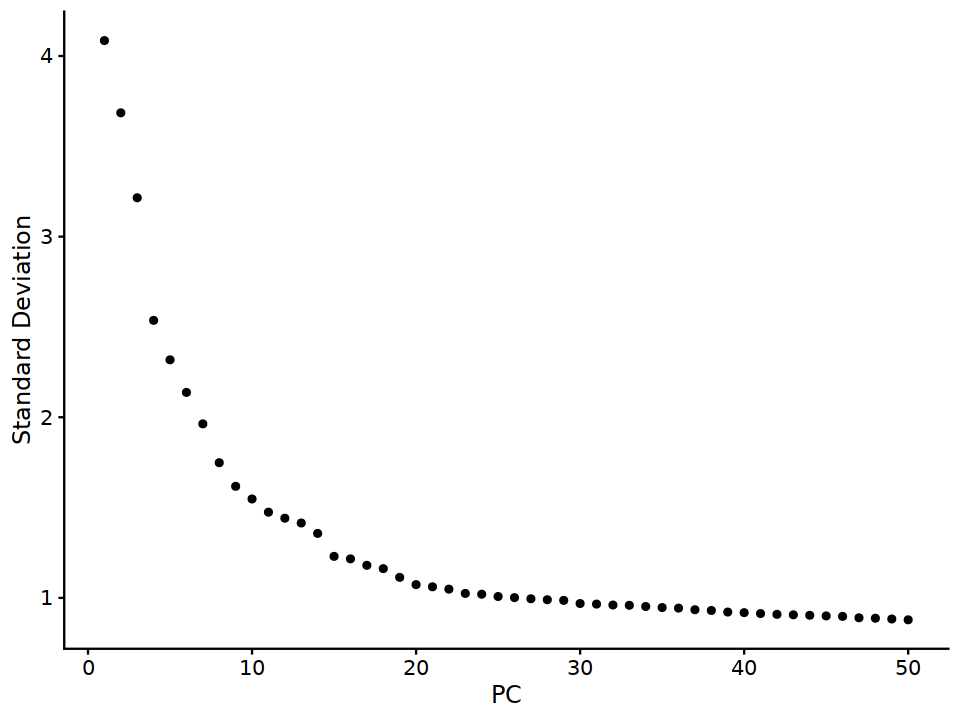

In [13]:
options(repr.plot.width = 8, repr.plot.height = 6)
ElbowPlot(seurat_obj, n=50)

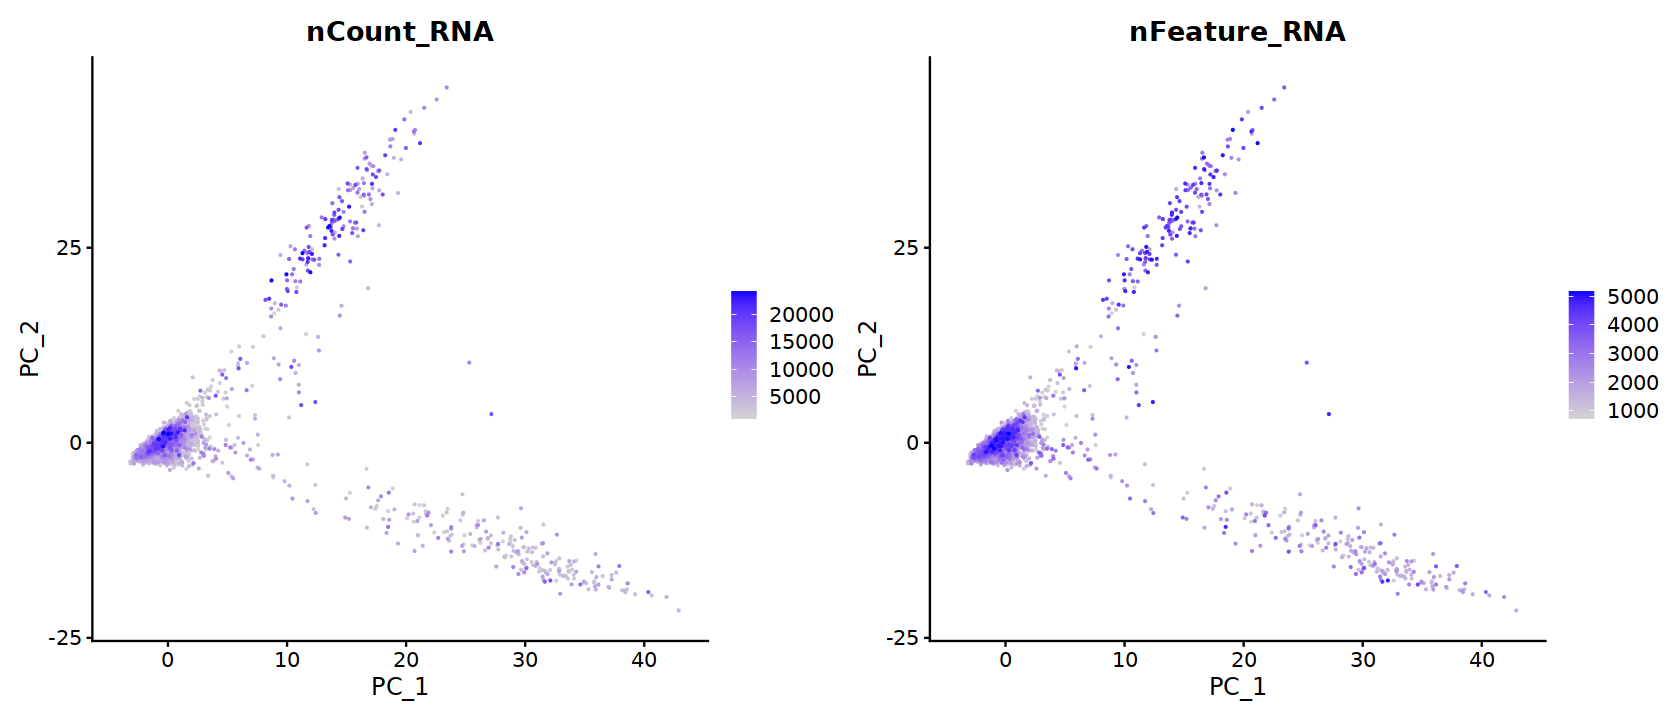

In [14]:
options(repr.plot.width = 14, repr.plot.height = 6)
FeaturePlot(object = seurat_obj, reduction = "pca",
        features = c("nCount_RNA","nFeature_RNA"), order=T)

## UMAP representation

In [15]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:20,
  reduction = "pca",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
11:27:06 UMAP embedding parameters a = 0.9922 b = 1.112

11:27:06 Read 14043 rows and found 20 numeric columns

11:27:06 Using Annoy for neighbor search, n_neighbors = 30

11:27:06 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:27:07 Writing NN index file to temp file /scratch_tmp/33937378/RtmpveEtkd/file16daa7f8c8556

11:27:07 Searching Annoy index using 1 thread, search_k = 3000

11:27:12 Annoy recall = 100%

11:27:12 Commencing smooth kNN distance calibration using 1 thread
 with t

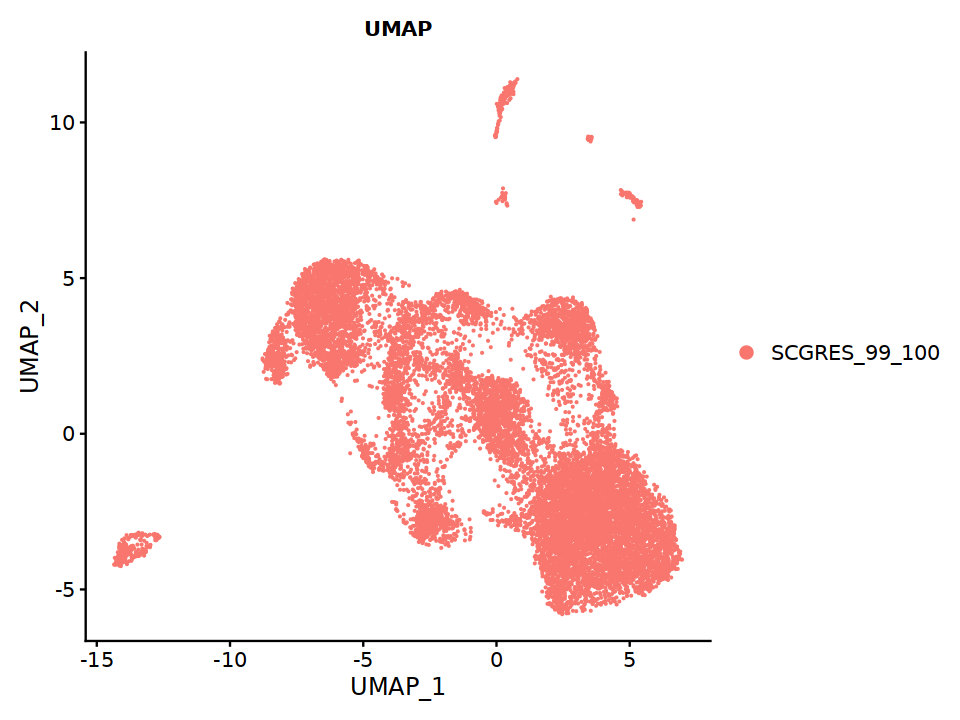

In [16]:
options(repr.plot.width = 8, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  pt.size = 0.1
) + ggtitle('UMAP') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

## More quality checks on UMAPs

### Compute Cell-Cycle Scores

In [17]:
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
seurat_obj <- CellCycleScoring(seurat_obj, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

### Plot several features

In [18]:
cat_vars <-c("Phase")
con_vars <- c("nCount_RNA", "nFeature_RNA", "pct_mt", "percent.ribo", 
              "doublet_score", "PTPRC", "COL1A2")
vars <- c(cat_vars, con_vars)

In [19]:
# compute plots
list_plots <- lapply(vars, function(var){
  if (var %in% cat_vars) {
      p <- DimPlot(seurat_obj, reduction = "umap", group.by=var)
  } else {
      p <- FeaturePlot(seurat_obj, reduction = "umap", feature=var, order = TRUE)
  }
  return(p)
})

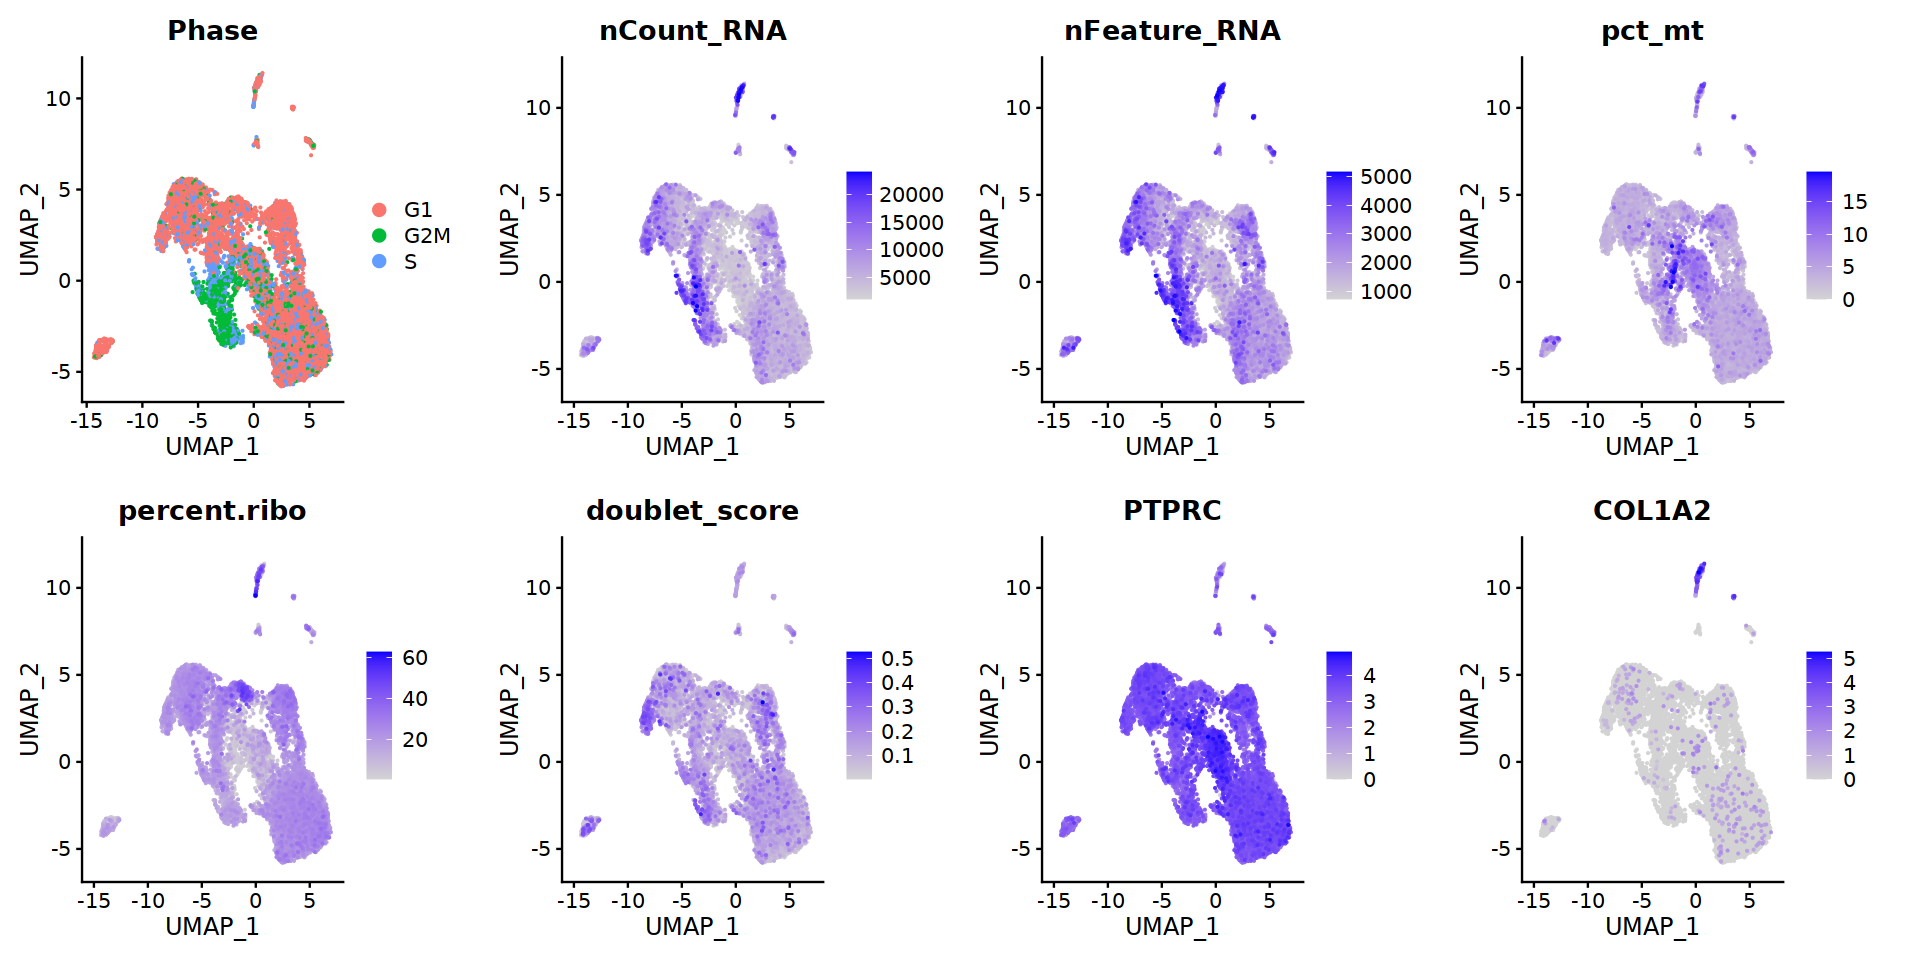

In [20]:
options(repr.plot.width = 16, repr.plot.height = 8, warn=-1,verbose = FALSE)
# show plots
cp <- cowplot::plot_grid(plotlist = list_plots,
                   align = "hv",
                   axis = "trbl",
                   ncol = 4,
                   nrow = 2)
cp

Plotting expression of some HVGs

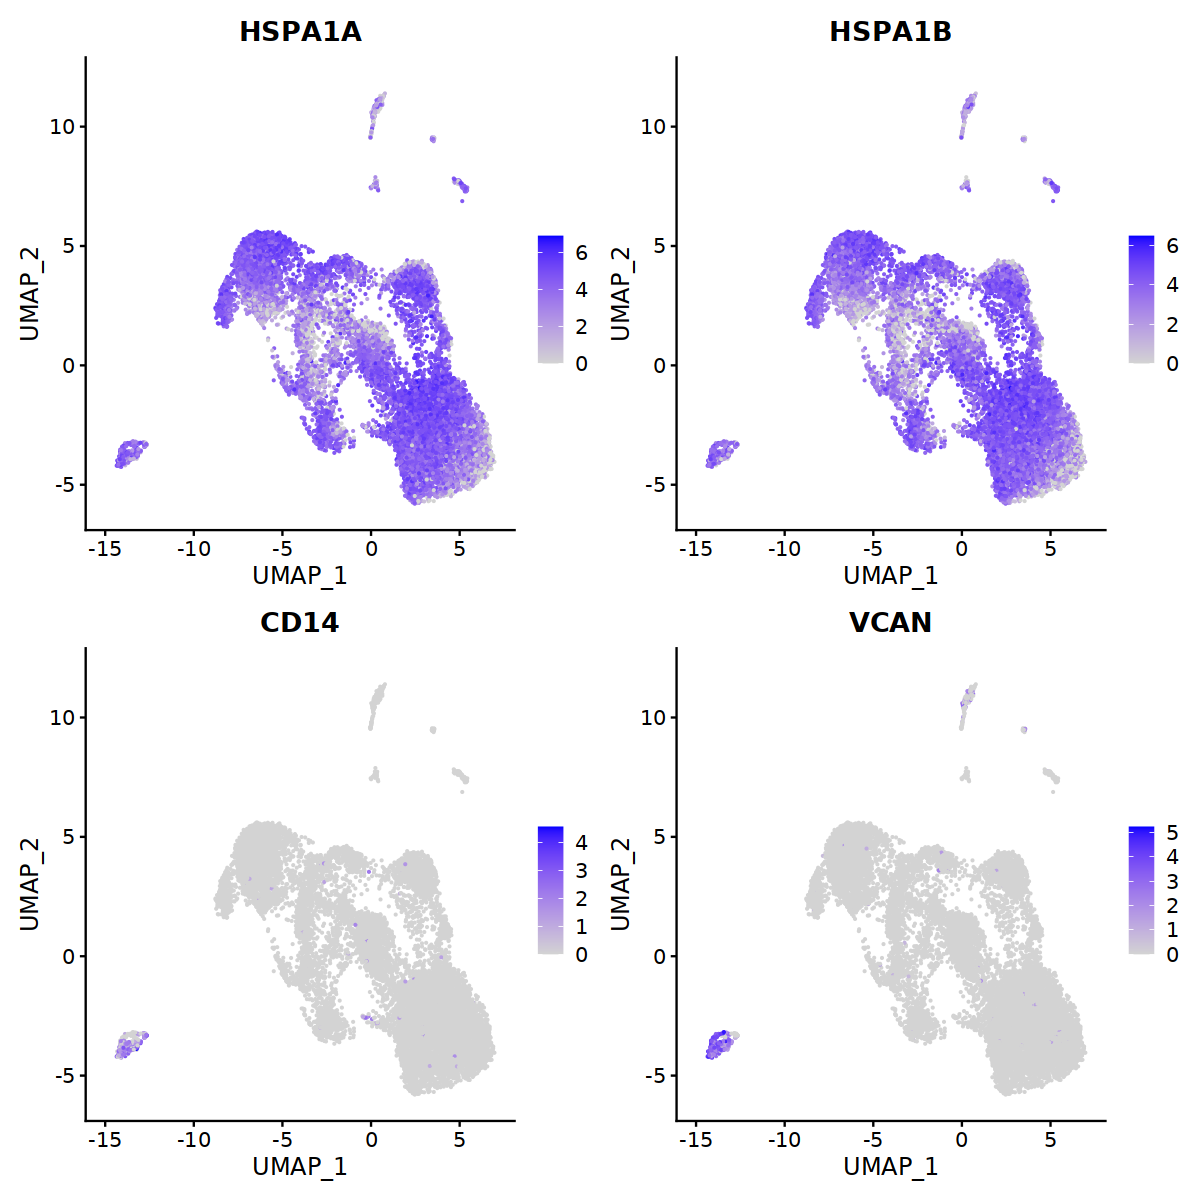

In [21]:
options(repr.plot.width = 10, repr.plot.height = 10, warn=-1,verbose = FALSE) 
FeaturePlot(seurat_obj, reduction = "umap", 
             feature=c("HSPA1A", "HSPA1B", "CD14", "VCAN"), order = FALSE)

# Save

In [22]:
saveRDS(seurat_obj, here::here(glue::glue("{clust}/{robj_dir}/dimred_combined_object_T0_CD3pos.rds")))

# Session Info

In [23]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scran_1.22.1                scater_1.22.0              
 [3] scuttle_1.4.0               SingleCellExperiment_1.16.0
 [5] SummarizedExperiment_1.24.0 Biobase_2.54.0             
 [7] GenomicRanges_1.46.1        GenomeInfoDb_1.30.1        
 [9] IRanges_